In [31]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 4.2 MB/s eta 0:00:00


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.9 MB/s eta 0:00:00


In [54]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import cv2
from ultralytics import YOLO
import torch
import numpy as np
import random

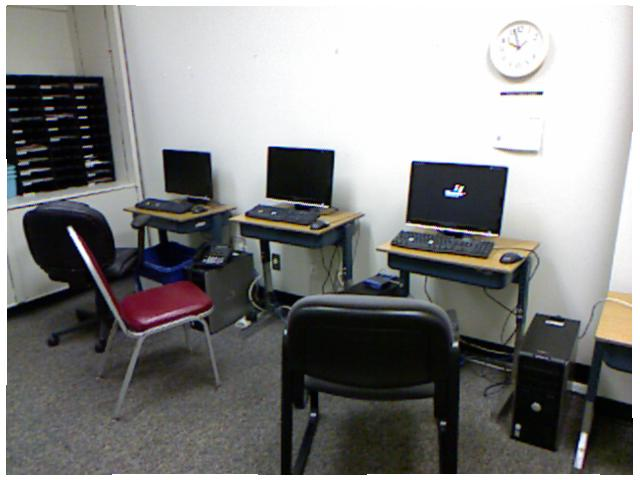

In [243]:
image = Image.open("/content/18.jpg")
image

In [244]:
checkpoint = "vinvino02/glpn-nyu"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [245]:
pixel_values = image_processor(image, return_tensors="pt").pixel_values

In [246]:
with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

In [247]:


# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()


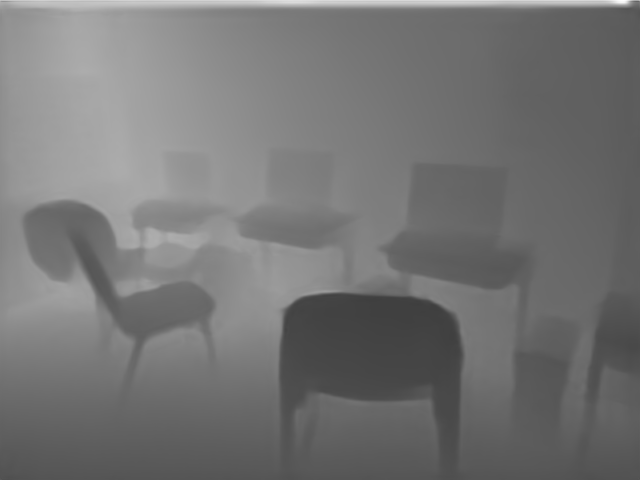

In [248]:
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

depth

In [249]:
ground_truth=cv2.imread('/content/18.png',cv2.IMREAD_GRAYSCALE)

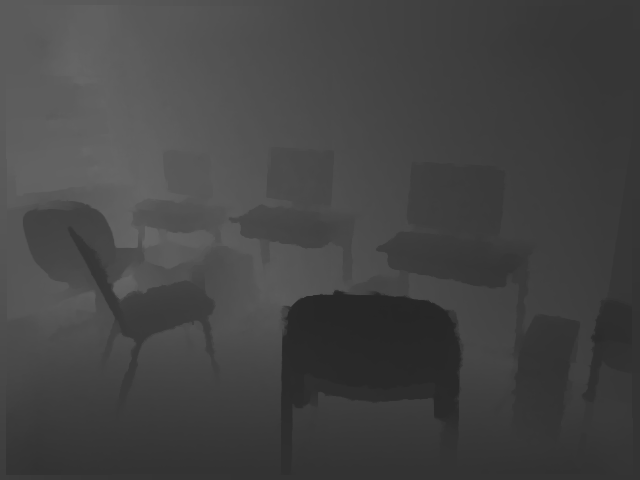

In [250]:
cv2_imshow(ground_truth)

In [251]:
model = YOLO('yolov8s.pt')  # pretrained YOLOv8n model


In [252]:

%%time
results = model(image ,imgsz=(480, 640) ,conf=0.5)# predict on an image


0: 480x640 3 chairs, 2 tvs, 1 laptop, 1 mouse, 3 keyboards, 1 clock, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


CPU times: user 211 ms, sys: 2.53 ms, total: 213 ms
Wall time: 212 ms


In [253]:
colors=np.random.uniform(low=0,high=255,size=(80,3))

In [254]:
names = list(results[0].names.values())

In [239]:
from google.colab.patches import cv2_imshow


In [255]:
im1=cv2.imread('/content/18.jpg')


In [256]:
im1.shape

(480, 640, 3)

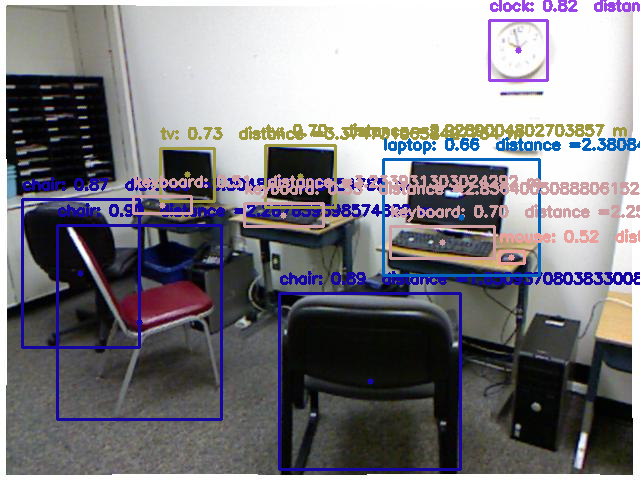

In [257]:
bboxs=[]
boxes = results[0].boxes

for obj in boxes.data:
  x, y, w,h=obj[0:4]
  bboxs.append(obj[0:4])
  lab=int(obj[5])
  prob=obj[4]
  cv2.rectangle(im1, (int(x), int(y)), (int(w), int(h)), colors[lab],2)
  cv2.circle(im1, (int((x+w)/2),int((y+h)/2)), radius=0, color=colors[lab], thickness=5)
  cv2.putText(im1, f"{names[lab]}: {prob:.2f}  distance ={output[int((y+h)/2)][int((x+w)/2)] } m ", (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[lab], 2)




cv2_imshow( im1)
